In [12]:
!pip install wget

In [13]:
!pip install astroquery

In [8]:
import legacy_for_img

import os
import sys

import pandas as pd
import numpy as np
import astropy.table as atpy

import torch, numpy
import matplotlib.pyplot as plt, pandas as pd, numpy as np
from torchvision import datasets, models, transforms, utils
import skimage, astropy.coordinates as coord, astropy.units as u
from torch.utils.data import Dataset, DataLoader

from astroquery.vizier import Vizier

# **Collect data**

In [9]:
!pip install pixell

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 15, in <module>
    from pip._vendor.packaging.requirements import Requirement
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/requirements.py", line 10, in <module>
    from pip._vendor.pyparsing import (  # noqa
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/py

In [10]:
from pixell import enmap
from astropy import units as u
from astropy.coordinates import Angle
import astropy.coordinates as coord

##**Import data and prepare**

In [11]:
# Карта покрытия ACT
!wget https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/maps/act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits

--2024-04-16 11:33:13--  https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/maps/act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114565760 (1.0G)
Saving to: ‘act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits.1’

ct_planck_dr5.01_s0   0%[                    ]   3.16M  1.31MB/s               ^C


In [117]:
# Скопления
!wget https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/DR5_cluster-catalog_v1.1.fits

--2024-04-16 10:38:20--  https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/DR5_cluster-catalog_v1.1.fits
Resolving lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)... 129.164.179.68, 2001:4d0:2310:150::68
Connecting to lambda.gsfc.nasa.gov (lambda.gsfc.nasa.gov)|129.164.179.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10612800 (10M)
Saving to: ‘DR5_cluster-catalog_v1.1.fits’

DR5_cluster-catalog 100%[===================>]  10.12M  1.73MB/s    in 7.2s    

2024-04-16 10:38:28 (1.40 MB/s) - ‘DR5_cluster-catalog_v1.1.fits’ saved [10612800/10612800]



In [14]:
dr5 = atpy.Table().read('/content/DR5_cluster-catalog_v1.1.fits').to_pandas().reset_index(drop=True)
dr5['name'] = [str(dr5.loc[i, 'name'], encoding='utf-8') for i in range(len(dr5))]

In [15]:
dr5

,name,RADeg,decDeg,SNR,y_c,err_y_c,fixed_SNR,fixed_y_c,fixed_err_y_c,template,...,RMDESY3_LAMBDA_CHISQ_E,CAMIRA,CAMIRA_N_mem,opt_RADeg,opt_decDeg,opt_positionSource,notes,knownLens,knownLensRefCode,warnings
0,ACT-CL J0000.0-3837,0.020898,-38.626732,4.793987,0.328228,0.068467,4.632617,0.466290,0.100654,b'Arnaud_M4e14_z0p2',...,2.881614,False,-99.000,0.023776,-38.626737,b'RMDESY3',NaN,NaN,NaN,NaN
1,ACT-CL J0000.2-4357,0.060601,-43.955494,7.678747,0.600471,0.078199,7.576226,0.734902,0.097001,b'Arnaud_M1e14_z0p2',...,4.824760,False,-99.000,0.071517,-43.957593,b'Vis-BCG',NaN,NaN,NaN,NaN
2,ACT-CL J0000.3-2805,0.089900,-28.091249,5.665297,0.681096,0.120223,4.661066,0.897845,0.192626,b'Arnaud_M8e14_z0p2',...,-99.000000,False,-99.000,0.096956,-28.103488,b'Vis-BCG',NaN,NaN,NaN,NaN
3,ACT-CL J0000.3-3936,0.083333,-39.604169,4.058639,0.277785,0.068443,3.906909,0.388540,0.099449,b'Arnaud_M4e14_z0p2',...,4.679606,False,-99.000,0.070362,-39.599268,b'RMDESY3',NaN,NaN,NaN,NaN
4,ACT-CL J0000.4-0102,0.113533,-1.044811,4.997832,0.296879,0.059402,4.450222,0.377924,0.084922,b'Arnaud_M8e14_z0p2',...,3.726360,False,-99.000,0.116001,-1.043040,b'Vis-BCG',NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,ACT-CL J2358.9-4354,359.727531,-43.905169,8.750438,0.552651,0.063157,8.031790,0.777166,0.096761,b'Arnaud_M8e14_z0p2',...,6.078207,False,-99.000,359.721236,-43.908118,b'RMDESY3',NaN,NaN,NaN,NaN
4191,ACT-CL J2359.5+0208,359.887357,2.138787,9.269819,0.624884,0.067411,8.896495,0.788134,0.088589,b'Arnaud_M2e14_z0p2',...,3.652331,True,64.955,359.889745,2.139955,b'Vis-BCG',NaN,"b'235933+020823,D20-2'","b'Jae20,H20a,D20'",NaN
4192,ACT-CL J2359.5-4608,359.889739,-46.143628,4.623512,1.126720,0.243693,4.236508,0.418773,0.098849,b'Arnaud_M1e14_z1p2',...,-99.000000,False,-99.000,359.907185,-46.135779,b'RMDESY3ACT',NaN,NaN,NaN,NaN
4193,ACT-CL J2359.7-5010,359.929865,-50.169857,8.924190,1.439237,0.161274,8.831121,0.921787,0.104379,b'Arnaud_M4e14_z1p2',...,4.243377,False,-99.000,359.928406,-50.167165,b'RMDESY3',NaN,NaN,NaN,NaN


In [16]:
radegDr5 = dr5.loc[:, "RADeg"]
decdegDr5 = dr5.loc[:, "decDeg"]

In [17]:
# the catalogue of MaCDoWs in VizieR
CATALOGUE = "J/ApJS/240/33"

In [18]:
catalog_list = Vizier.find_catalogs(CATALOGUE)

In [19]:
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())
catalogs

TableList with 4 tables:
	'0:J/ApJS/240/33/table3' with 26 column(s) and 2433 row(s) 
	'1:J/ApJS/240/33/table4' with 16 column(s) and 250 row(s) 
	'2:J/ApJS/240/33/table5' with 22 column(s) and 156 row(s) 
	'3:J/ApJS/240/33/table6' with 9 column(s) and 1716 row(s) 

In [20]:
interesting_table = catalogs['J/ApJS/240/33/table3']
madCows_table = interesting_table.to_pandas().reset_index(drop=True)
madCows_table = madCows_table.iloc[:, [1, 2, 3]]
madCows_table

,Name,RAJ2000,DEJ2000
0,MOO J0001+1428,00 01 09.1,+14 28 57
1,MOO J0001+3644,00 01 09.8,+36 44 38
2,MOO J0001+3440,00 01 38.5,+34 40 50
3,MOO J0001-2447,00 01 49.4,-24 47 32
4,MOO J0001-2533,00 01 54.7,-25 33 35
...,...,...,...
2428,MOO J2358+1836,23 58 48.3,+18 36 34
2429,MOO J2358-2602,23 58 49.0,-26 02 11
2430,MOO J2359+2413,23 59 52.2,+24 13 44
2431,MOO J2359+1329,23 59 53.1,+13 29 02


In [21]:
def toHmsFormat(s):
    l = s.split()
    s = l[0]+'h'+l[1]+'m'+l[2]+'s'
    return s

def toDmsFormat(s):
    l = s.split()
    s = l[0]+'d'+l[1]+'m'+l[2]+'s'
    return s

In [22]:
radegMC = madCows_table.iloc[:, 1].apply(lambda x: Angle(toHmsFormat(x)).degree)
decdegMC = madCows_table.iloc[:, 2].apply(lambda x: Angle(toDmsFormat(x)).degree)

In [23]:
clustersDr5_MC = pd.DataFrame(
    {
        'name': pd.concat([dr5['name'], madCows_table['Name']], ignore_index=True),
        'RADeg': pd.concat([radegDr5, radegMC], ignore_index=True),
        'decDeg': pd.concat([decdegDr5, decdegMC], ignore_index=True)
    }
)
clustersDr5_MC

,name,RADeg,decDeg
0,ACT-CL J0000.0-3837,0.020898,-38.626732
1,ACT-CL J0000.2-4357,0.060601,-43.955494
2,ACT-CL J0000.3-2805,0.089900,-28.091249
3,ACT-CL J0000.3-3936,0.083333,-39.604169
4,ACT-CL J0000.4-0102,0.113533,-1.044811
...,...,...,...
6623,MOO J2358+1836,359.701250,18.609444
6624,MOO J2358-2602,359.704167,-26.036389
6625,MOO J2359+2413,359.967500,24.228889
6626,MOO J2359+1329,359.971250,13.483889


##**Create negative class from dr5**

In [24]:
path = '/content/'

In [25]:
!pwd

/content


In [26]:
imap_98 = enmap.read_fits(path + 'act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits')[0]

In [27]:
positions = np.array(np.rad2deg(imap_98.posmap()))
# ras = radegDr5
# decs = decdegDr5
ras, decs = positions[1], positions[0]
ras, decs = ras.ravel(), decs.ravel()
rac = ras[np.random.choice(len(ras), size=100000, replace=False)] + np.random.normal(-0.1,0.1, 100000)
dec = decs[np.random.choice(len(decs), size=100000, replace=False)] + np.random.normal(-0.1,0.1, 100000)

# rac = ras[np.random.choice(len(ras), size=100000)] + np.random.normal(-0.1,0.1, 100000)
# dec = decs[np.random.choice(len(decs), size=100000)] + np.random.normal(-0.1,0.1, 100000)

In [28]:
ra = []
de = []
name = []
n = 0
c = coord.SkyCoord(ra = clustersDr5_MC['RADeg']*u.degree, dec = clustersDr5_MC['decDeg']*u.degree, unit='deg')
for i in range(len(rac)):
    coords = coord.SkyCoord(ra=rac[i]*u.degree, dec=dec[i]*u.degree, frame='icrs')
    idx, d2d, d3d = coords.match_to_catalog_sky(c)
    if d2d.arcmin < 10:
        continue
    b = coords.galactic.b.degree
    l = coords.galactic.l.degree
    if b > 20:
        ra.append(coords.ra.degree)
        de.append(coords.dec.degree)
        name.append(f'Rand {l:.3f}{b:+.3f}')
        n += 1
    if n == len(dr5):
        break

In [29]:
dfNegativeFromDr5 = pd.DataFrame({'Component_name': name, 'RA': ra, 'DEC': de})

In [30]:
dfNegativeFromDr5

,Component_name,RA,DEC
0,Rand 292.265+30.712,182.129239,-31.268844
1,Rand 269.828+31.050,162.102709,-23.798220
2,Rand 283.117+43.874,178.077568,-16.711364
3,Rand 26.308+30.507,252.708547,8.222638
4,Rand 269.594+31.980,162.457248,-22.904222
...,...,...,...
4190,Rand 345.218+44.234,222.060468,-8.839289
4191,Rand 357.011+60.559,216.564741,8.074595
4192,Rand 344.913+38.185,225.633587,-13.776667
4193,Rand 259.236+72.114,180.247119,13.669537


##**Final data_dr5 with positive and negative classes**

In [31]:
clusters = dr5
clusters = clusters[['name', 'RADeg', 'decDeg']].reset_index(drop=True)
clusters.rename(columns = {'name': 'Component_name', 'RADeg': 'RA', 'decDeg': 'DEC'}, inplace = True )
clusters['target'] = 1
random = dfNegativeFromDr5
random['target'] = 0
data_dr5 = pd.concat([clusters, random]).reset_index(drop=True)
data_dr5

,Component_name,RA,DEC,target
0,ACT-CL J0000.0-3837,0.020898,-38.626732,1
1,ACT-CL J0000.2-4357,0.060601,-43.955494,1
2,ACT-CL J0000.3-2805,0.089900,-28.091249,1
3,ACT-CL J0000.3-3936,0.083333,-39.604169,1
4,ACT-CL J0000.4-0102,0.113533,-1.044811,1
...,...,...,...,...
8385,Rand 345.218+44.234,222.060468,-8.839289,0
8386,Rand 357.011+60.559,216.564741,8.074595,0
8387,Rand 344.913+38.185,225.633587,-13.776667,0
8388,Rand 259.236+72.114,180.247119,13.669537,0


##**Create negative class from Macdows**

In [32]:
def createNegativeClassRac(x):
    randChoice = np.random.normal(-15, 15)
    while (x + randChoice) > 360 or (x + randChoice) < 0:
      randChoice = np.random.normal(-15, 15)
    return x + randChoice


def createNegativeClassDec(x):
    randChoice = np.random.normal(-15, 15)
    while (x + randChoice) > 90 or (x + randChoice) < -90:
        randChoice = np.random.normal(-15, 15)
    return x + randChoice

In [33]:
rac = radegMC[np.random.choice(len(radegMC), size=10000)].apply(lambda x: createNegativeClassRac(x))
dec = decdegMC[np.random.choice(len(decdegMC), size=10000)].apply(lambda x: createNegativeClassDec(x))
rac, dec = rac.ravel(), dec.ravel()

In [34]:
ra = []
de = []
name = []
n = 0
c = coord.SkyCoord(ra = clustersDr5_MC['RADeg']*u.degree, dec = clustersDr5_MC['decDeg']*u.degree, unit='deg')
for i in range(len(rac)):
    coords = coord.SkyCoord(ra=rac[i]*u.degree, dec=dec[i]*u.degree, frame='icrs')
    idx, d2d, d3d = coords.match_to_catalog_sky(c)
    if d2d.arcmin < 10:
        continue
    b = coords.galactic.b.degree
    l = coords.galactic.l.degree
    if b > 20:
        ra.append(coords.ra.degree)
        de.append(coords.dec.degree)
        name.append(f'Rand {l:.3f}{b:+.3f}')
        n += 1
    if n == len(madCows_table):
        break

In [35]:
dfNegativeFromMacdows = pd.DataFrame({'Component_name': name, 'RA': ra, 'DEC': de})
dfNegativeFromMacdows

,Component_name,RA,DEC
0,Rand 239.942+35.086,145.909179,-3.935508
1,Rand 292.309+23.860,180.507228,-37.990137
2,Rand 270.364+49.843,172.350357,-7.769546
3,Rand 149.334+38.396,136.587815,65.226246
4,Rand 291.911+25.621,180.526545,-36.193149
...,...,...,...
2428,Rand 292.998+30.227,182.751357,-31.863841
2429,Rand 219.353+29.422,131.951768,7.892174
2430,Rand 223.172+29.400,133.483640,4.933463
2431,Rand 312.832+37.628,201.471049,-24.580877


##**Final data_macdows with positive and negative classes**



In [36]:
clusters = pd.DataFrame({'Component_name': madCows_table['Name'], 'RA': radegMC, 'DEC': decdegMC})
clusters['target'] = 1
random = dfNegativeFromMacdows
random['target'] = 0
data_macdows = pd.concat([clusters, random]).reset_index(drop=True)
data_macdows

,Component_name,RA,DEC,target
0,MOO J0001+1428,0.287917,14.482500,1
1,MOO J0001+3644,0.290833,36.743889,1
2,MOO J0001+3440,0.410417,34.680556,1
3,MOO J0001-2447,0.455833,-24.792222,1
4,MOO J0001-2533,0.477917,-25.559722,1
...,...,...,...,...
4861,Rand 292.998+30.227,182.751357,-31.863841,0
4862,Rand 219.353+29.422,131.951768,7.892174,0
4863,Rand 223.172+29.400,133.483640,4.933463,0
4864,Rand 312.832+37.628,201.471049,-24.580877,0


#**Test val and test data**

In [141]:
folderlocation = '/content/data/Data224/'

path = folderlocation
os.makedirs(path, exist_ok=True)

path = folderlocation + 'train/'
os.makedirs(path, exist_ok=True)

path = folderlocation + 'val/'
os.makedirs(path, exist_ok=True)

path = folderlocation + 'test_dr5/'
os.makedirs(path, exist_ok=True)

path = folderlocation + 'test_macdows/'
os.makedirs(path, exist_ok=True)


for iter1 in range(2):
    path = folderlocation + 'train/'+str(iter1)
    os.makedirs(path, exist_ok=True)

    path = folderlocation + 'val/'+str(iter1)
    os.makedirs(path, exist_ok=True)

    path = folderlocation + 'test_dr5/'+str(iter1)
    os.makedirs(path, exist_ok=True)

    path = folderlocation + 'test_macdows/'+str(iter1)
    os.makedirs(path, exist_ok=True)

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data_dr5.index, data_dr5['target'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [39]:
X_train

Index([4265, 1148, 2390,   17, 4348, 8141, 6013, 1991,  497, 8165,
       ...
        514, 7225, 2109, 6760, 5800,   22, 6545, 3752, 8247, 1166],
      dtype='int64', length=5034)

In [40]:
y_train

4265    0
1148    1
2390    1
17      1
4348    0
       ..
22      1
6545    0
3752    1
8247    0
1166    1
Name: target, Length: 5034, dtype: int64

In [41]:
train = data_dr5.iloc[X_train].reset_index(drop=True)
val = data_dr5.iloc[X_val].reset_index(drop=True)
test_dr5 = data_dr5.iloc[X_test].reset_index(drop=True)

In [42]:
train_0 = train[train.target == 0].reset_index(drop=True)
train_1 = train[train.target == 1].reset_index(drop=True)

val_0 = val[val.target == 0].reset_index(drop=True)
val_1 = val[val.target == 1].reset_index(drop=True)

test_dr5_0 = test_dr5[test_dr5.target == 0].reset_index(drop=True)
test_dr5_1 = test_dr5[test_dr5.target == 1].reset_index(drop=True)

test_macdows_0 = data_macdows[data_macdows.target == 0].reset_index(drop=True)
test_macdows_1 = data_macdows[data_macdows.target == 1].reset_index(drop=True)

In [148]:
legacy_for_img.grab_cutouts(target_file=train_0, output_dir='./data/Data224/train/0',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=train_1, output_dir='./data/Data224/train/1',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=val_0, output_dir='./data/Data224/val/0',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=val_1, output_dir='./data/Data224/val/1',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=test_dr5_0, output_dir='./data/Data224/test_dr5/0',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=test_dr5_1, output_dir='./data/Data224/test_dr5/1',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=test_macdows_0, output_dir='./data/Data224/test_macdows/0',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

legacy_for_img.grab_cutouts(target_file=test_macdows_1, output_dir='./data/Data224/test_macdows/1',
                                          survey='unwise-neo7', imgsize_pix = 224, file_format='jpg')

Выходные данные были обрезаны до нескольких последних строк (5000).
Failed attempt 1 to download ./data/Data224/test_dr5/1/519.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/520.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/533.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/536.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/535.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/522.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/526.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/532.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/534.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/531.jpg with an HTTPError
Failed attempt 0 to download ./data/Data224/test_dr5/1/529.jpg with an HTTPError
Failed attempt 0 to download ./data/Data2

*In case collection of pictures is taking too much time, for test purposes use your own file*

In [149]:
# # To download collected data to your computer use:
# !zip -r /content/collectedLegacyData.zip /content/data
# from google.colab import files
# files.download("/content/collectedLegacyData.zip")

#**Dataloader**


In [43]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(15,),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
     'test_dr5': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
      'test_macdows': transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

In [44]:
folderlocation = '/content/data/Data224/'
data_dir = folderlocation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test_dr5', 'test_macdows']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=3)
              for x in ['train', 'val', 'test_dr5', 'test_macdows']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test_dr5', 'test_macdows']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


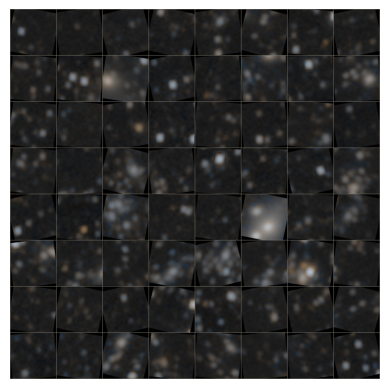

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.507, 0.487, 0.441])
    std = numpy.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

In [47]:
!ls /content/data/Data224/train/0 -1 | wc -l
!ls /content/data/Data224/train/1 -1 | wc -l

!ls /content/data/Data224/val/0 -1 | wc -l
!ls /content/data/Data224/val/1 -1 | wc -l

!ls /content/data/Data224/test_dr5/0 -1 | wc -l
!ls /content/data/Data224/test_dr5/1 -1 | wc -l

!ls /content/data/Data224/test_macdows/0 -1 | wc -l
!ls /content/data/Data224/test_macdows/1 -1 | wc -l

2488
2546
844
834
863
815
2433
2433


#**Pixel prediction**

In [48]:
import legacy_for_img

from PIL import Image
from pixell import enmap

In [49]:
class ImageSet(Dataset):
    def __init__(self, dir, transform=None):
        self.data_dir = dir
        self.images = os.listdir(dir)
        self.images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
        self.transform = transform

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.images[index])
        image = Image.open(image_path)

        # Applying the transform
        if self.transform:
            image = self.transform(image)

        return image

In [50]:
!pip install timm

In [51]:
import timm

In [70]:
df = test_dr5

In [53]:
model_ft = timm.create_model('resnet18', pretrained=True, num_classes=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [54]:
def predict_folder(folder, device='cuda:0'):
    model = model_ft.to(device)
    model.load_state_dict(torch.load('/content/ResNet_epoch_3.pth', map_location=device))
    model.eval()

    trans = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

    data = ImageSet(folder, transform=trans)
    data_load = DataLoader(data, batch_size = 5, shuffle=False)
    probs = np.array([])
    for i, data in enumerate(data_load):
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        img = data.to(device)

        #model prediction
        outputs = model(img)
        probs = np.append(probs, outputs.data.cpu().detach().numpy())
    # return np.array(probs)
    return np.array(probs)

In [162]:
# clust = df[df.target==1].reset_index(drop=True)
# clust.shape

In [163]:
# print(predict_folder('/content/data/Data224/test/1', device='cpu'))

In [71]:
clust = df[df.target==1].reset_index(drop=True)
clust['prob'] = predict_folder('/content/data/Data224/test_dr5/1', device=device)
rand = df[df.target==0].reset_index(drop=True)
rand['prob'] = predict_folder('/content/data/Data224/test_dr5/0', device=device)

In [72]:
clust

,Component_name,RA,DEC,target,prob
0,ACT-CL J0052.7-4551,13.195057,-45.860752,1,-0.081435
1,ACT-CL J0455.7-3417,73.935117,-34.285073,1,-0.013085
2,ACT-CL J1319.6+1553,199.909131,15.890405,1,-0.059698
3,ACT-CL J0131.4-5921,22.866006,-59.352828,1,-0.047672
4,ACT-CL J0345.3-2044,56.349997,-20.743351,1,0.040552
...,...,...,...,...,...
810,ACT-CL J0818.4+0310,124.620835,3.169403,1,-0.046451
811,ACT-CL J0137.4-0009,24.366678,-0.160347,1,0.035029
812,ACT-CL J1057.0+0929,164.272673,9.494385,1,0.049533
813,ACT-CL J0154.5-5618,28.637495,-56.316667,1,0.029295


In [132]:
folderlocation = './data/example/'

path = folderlocation
os.makedirs(path, exist_ok=True)

path = folderlocation + 'Cl/'
os.makedirs(path, exist_ok=True)

path = folderlocation + 'R/'
os.makedirs(path, exist_ok=True)

for iter1 in range(5):    # 100 = number of classes
    path = folderlocation + 'Cl/'+str(iter1)
    os.makedirs(path, exist_ok=True)

    path = folderlocation + 'R/'+str(iter1)
    os.makedirs(path, exist_ok=True)

In [133]:
r5 = rand[rand.target==0].sample(5, random_state=5).reset_index(drop=True)
r5.to_csv('./data/example/r5.csv',index=False)

cl5 = clust[clust.target==1].sample(5, random_state=5).reset_index(drop=True)
cl5.to_csv('./data/example/cl5.csv',index=False)

In [134]:
cl5

,Component_name,RA,DEC,target,prob
0,ACT-CL J2309.2-4744,347.301974,-47.739180,1,-0.048682
1,ACT-CL J0546.9-3904,86.749945,-39.072643,1,-0.070949
2,ACT-CL J2359.5-4608,359.889739,-46.143628,1,0.148759
3,ACT-CL J0359.7-2435,59.937457,-24.587430,1,0.026249
4,ACT-CL J1309.7+1305,197.445275,13.089380,1,-0.056374


In [135]:
# !wget https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr5/maps/act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits

In [136]:
def get_img(ra, de, name, dire):
    width = 1
    box = np.deg2rad([[de-width/2.,ra-width/2.],[de+width/2.,ra+width/2.]])
    pixbox = np.array([[0, 0,], [20, 20]])
    imap_98 = enmap.read_map('act_planck_dr5.01_s08s18_AA_f220_daynight_fullivar.fits', box=box, pixbox=pixbox)[0]
    decs, ras = np.array(np.rad2deg(imap_98.posmap()))
    decs, ras = decs.ravel(), ras.ravel()
    ras=coord.SkyCoord(ra=ras*u.degree, dec=decs*u.degree, frame='icrs').ra.degree

    data = pd.DataFrame({'Component_name': name, 'RA': ras, 'DEC': decs})
    legacy_for_img.grab_cutouts(target_file=data, output_dir=dire,
                                          survey='unwise-neo7', imgsize_pix = 224*8, file_format='jpg' )
    #return data

In [137]:
cl5 = pd.read_csv('./data/example/cl5.csv')
r5 =  pd.read_csv('./data/example/r5.csv')

In [138]:
cl5

,Component_name,RA,DEC,target,prob
0,ACT-CL J2309.2-4744,347.301974,-47.739180,1,-0.048682
1,ACT-CL J0546.9-3904,86.749945,-39.072643,1,-0.070949
2,ACT-CL J2359.5-4608,359.889739,-46.143628,1,0.148759
3,ACT-CL J0359.7-2435,59.937457,-24.587430,1,0.026249
4,ACT-CL J1309.7+1305,197.445275,13.089380,1,-0.056374


In [139]:
get_img(cl5.loc[0, 'RA'], cl5.loc[0, 'DEC'], cl5.loc[0, 'Component_name'], dire = './data/example/Cl/0')
get_img(cl5.loc[1, 'RA'], cl5.loc[1, 'DEC'], cl5.loc[1, 'Component_name'], dire = './data/example/Cl/1')
get_img(cl5.loc[2, 'RA'], cl5.loc[2, 'DEC'], cl5.loc[2, 'Component_name'], dire = './data/example/Cl/2')
get_img(cl5.loc[3, 'RA'], cl5.loc[3, 'DEC'], cl5.loc[3, 'Component_name'], dire = './data/example/Cl/3')
get_img(cl5.loc[4, 'RA'], cl5.loc[4, 'DEC'], cl5.loc[4, 'Component_name'], dire = './data/example/Cl/4')

get_img(r5.loc[0, 'RA'], r5.loc[0, 'DEC'], r5.loc[0, 'Component_name'], dire = './data/example/R/0')
get_img(r5.loc[1, 'RA'], r5.loc[1, 'DEC'], r5.loc[1, 'Component_name'], dire = './data/example/R/1')
get_img(r5.loc[2, 'RA'], r5.loc[2, 'DEC'], r5.loc[2, 'Component_name'], dire = './data/example/R/2')
get_img(r5.loc[3, 'RA'], r5.loc[3, 'DEC'], r5.loc[3, 'Component_name'], dire = './data/example/R/3')
get_img(r5.loc[4, 'RA'], r5.loc[4, 'DEC'], r5.loc[4, 'Component_name'], dire = './data/example/R/4')

20
20
20
20
20
20
20
20
20
20


In [140]:
prob_clust0 = predict_folder('./data/example/Cl/0', device=device)
prob_clust1 = predict_folder('./data/example/Cl/1', device=device)
prob_clust2 = predict_folder('./data/example/Cl/2', device=device)
prob_clust3 = predict_folder('./data/example/Cl/3', device=device)
prob_clust4 = predict_folder('./data/example/Cl/4', device=device)

prob_r0 = predict_folder('./data/example/R/0', device=device)
prob_r1 = predict_folder('./data/example/R/1', device=device)
prob_r2 = predict_folder('./data/example/R/2', device=device)
prob_r3 = predict_folder('./data/example/R/3', device=device)
prob_r4 = predict_folder('./data/example/R/4', device=device)

In [141]:
import matplotlib as mpl
from matplotlib import cm

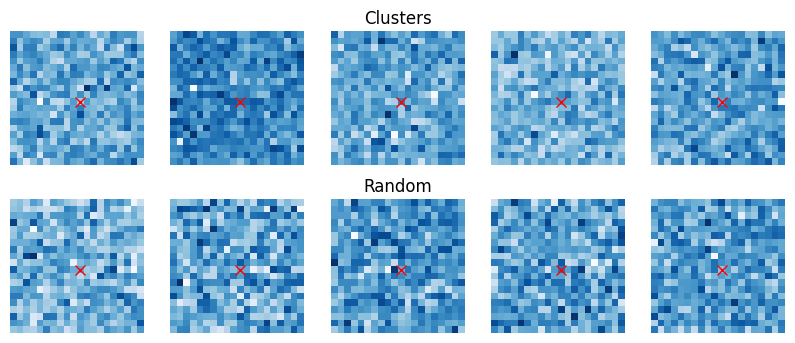

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

ax[0, 0].imshow(prob_clust0.reshape(20,20), cmap = cm.Blues)
ax[0, 1].imshow(prob_clust1.reshape(20,20), cmap = cm.Blues)
ax[0, 2].imshow(prob_clust2.reshape(20,20), cmap = cm.Blues)
ax[0, 3].imshow(prob_clust3.reshape(20,20), cmap = cm.Blues)
ax[0, 4].imshow(prob_clust4.reshape(20,20), cmap = cm.Blues)

ax[0, 2].set_title('Clusters')
ax[1, 2].set_title('Random')

ax[1, 0].imshow(prob_r0.reshape(20,20), cmap = cm.Blues)
ax[1, 1].imshow(prob_r1.reshape(20,20), cmap = cm.Blues)
ax[1, 2].imshow(prob_r2.reshape(20,20), cmap = cm.Blues)
ax[1, 3].imshow(prob_r3.reshape(20,20), cmap = cm.Blues)
ax[1, 4].imshow(prob_r4.reshape(20,20), cmap = cm.Blues)
for j in range(2):
    for i in range(5):
        ax[j, i].axis('off')
        ax[j, i].plot(10, 10, 'x', ms=7, color='red')

plt.show()

In [143]:
folderlocation = './data/example/Big'

path = folderlocation
os.makedirs(path, exist_ok=True)

In [144]:
def createMap(ra0, dec0, name, dire):
    shift = 5 / 60 #отступ на 5 минут в градусах
    step = 0.5 / 60 #шаг в 0.5 минуту
    name = []
    ras, decs = [], []
    ra1, dec_current = ra0 + shift, dec0 - shift #ra шагаем вправо, dec шагаем вниз
    switch = 0

    for i in range(0, 100, 5): #10 минут - максимальное расстояние подряд в одну сторону, 0.5 минута - один шаг
        ra_current = ra1
        for j in range(0, 100, 5):
            coords = coord.SkyCoord(ra=ra_current*u.degree, dec=dec_current*u.degree, frame='icrs')
            ras.append(coords.ra.degree)
            decs.append(coords.dec.degree)
            name.append(f'Map {l:.3f}{b:+.3f}')
            ra_current += step
            if (0 > ra_current  or ra_current > 360):
              break
        dec_current -= step
        if (-90 > dec_current or dec_current > 90):
          break

    data = pd.DataFrame({'Component_name': name, 'RA': ras, 'DEC': decs})
    legacy_for_img.grab_cutouts(target_file=data, output_dir=dire,
                                          survey='unwise-neo7', imgsize_pix = 20*20, file_format='jpg' )
    # print(data)
    # return data.shape

In [145]:
df = pd.concat([test_dr5, data_macdows], ignore_index=True)

In [146]:
cl0 = df[df.target==1].sample(1, random_state=1).reset_index(drop=True)
cl0

,Component_name,RA,DEC,target
0,MOO J0157-1556,29.252917,-15.943611,1


In [147]:
createMap(cl0.loc[0, 'RA'], cl0.loc[0, 'DEC'], cl0.loc[0, 'Component_name'], dire='./data/example/Big')

20
Failed attempt 0 to download ./data/example/Big/22.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/29.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/35.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/21.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/28.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/27.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/37.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/38.jpg with an HTTPError
Failed attempt 0 to download ./data/example/Big/39.jpg with an HTTPErrorFailed attempt 0 to download ./data/example/Big/32.jpg with an HTTPError

Failed attempt 1 to download ./data/example/Big/37.jpg with an HTTPError
Failed attempt 1 to download ./data/example/Big/28.jpg with an HTTPError
Failed attempt 1 to download ./data/example/Big/39.jpg with an HTTPError
Failed attempt 1 to download ./data/example/Big/

In [148]:
prob_big = predict_folder('./data/example/Big', device=device)

(-0.5, 19.5, 19.5, -0.5)

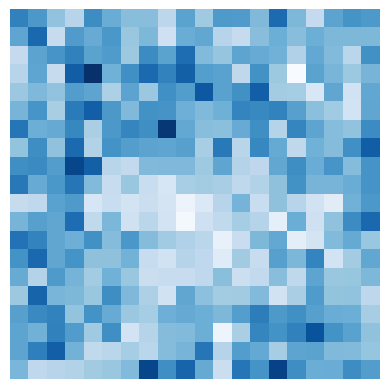

In [149]:
plt.imshow(prob_big.reshape(20, 20), cmap=cm.Blues)
plt.axis('off')